In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

In [2]:
# square lattice
l = 2

def does_percolate_y(r1,r2,loss_inds):
    # assuming periodic bc for x
    Gy = nx.Graph()
    Gy.add_nodes_from(np.arange(r1*r2))

    for i2 in range(r2):
        for i1 in range(r1):
            ind1 = i2*r1+ i1
            ind2 = i2*r1 + ((i1+1)%r1)
            # cylinder along y
            if 2*ind1 in loss_inds:
                Gy.add_edge(ind1,ind2)
            if ind1 +r1 < r1*r2 and 2*ind1+1 in loss_inds:
                Gy.add_edge(ind1,ind1+r1)
    # nx.draw(Gy, with_labels=True, font_weight='bold')

    first_row = np.arange(r1)
    last_row = np.arange((r2-1)*r1,r2*r1)
    path_y = 0
    for i_first in first_row:
        for i_last in last_row:
            if nx.has_path(Gy,i_first,i_last):
                path_y = 1
                break

    return path_y

def does_percolate_x(r1,r2,loss_inds):
    Gx = nx.Graph()
    Gx.add_nodes_from(np.arange((r1+1)*r2))

    for i2 in range(r2):
        for i1 in range(r1):
            ind1 = i2*r1+ i1
            # cylinder along x
            ind2 = ((i2+1)%r2)*r1 + i1
            i2_g = ((i2+1)%r2)*(r1+1) + i1
            i1_g = i2*(r1+1)+ i1
            if 2*ind1+1 in loss_inds:
                Gx.add_edge(i1_g,i2_g)
                if i1 == 0 :
                    Gx.add_edge(i1_g+r1,i2_g+r1) 
            if 2*ind1 in loss_inds:
                Gx.add_edge(i1_g,i1_g+1)
    # nx.draw(Gx, with_labels=True, font_weight='bold')
    
    first_col = np.arange(0,(r2-1)*(r1+1)+1,r1+1)
    last_col = np.arange(r1,r2*(r1+1)+1,r1+1)
    path_x = 0
    for i_first in first_col:
        for i_last in last_col:
            if nx.has_path(Gx,i_first,i_last):
                if int(i_first/(r1+1)) == int(i_last/(r1+1)):
                    path_x = 1
                    break
    
    return path_x


def does_percolate_obc(r1,r2,loss_inds):
    G = nx.Graph()
    G.add_nodes_from(range(r1*r2))
    
    for i2 in range(r2-1):
        for i1 in range(r1-1):
            ind1 = i2*r1+ i1
            ind2 = i2*r1 + i1+1
            #  along x
            if 2*ind1 in loss_inds:
                G.add_edge(ind1,ind2)
            #  along y
            ind2 = (i2+1)*r1 + i1
            if 2*ind1+1 in loss_inds:
                G.add_edge(ind1,ind2)
    for i2 in range(r2-1):
        ind1 = i2*r1+ r1 -1 
        ind2 = (i2+1)*r1 + r1 -1
        # along y
        if 2*ind1+1 in loss_inds:
            G.add_edge(ind1,ind2)
    for i1 in range(r1-1):
        ind1 = (r2-1)*r1+ i1
        ind2 = (r2-1)*r1 + i1+1
        #  along x
        if 2*ind1 in loss_inds:
            G.add_edge(ind1,ind2)

    first_row = np.arange(r1)
    last_row = np.arange((r2-1)*r1,r2*r1)
    path_y = 0
    for i_first in first_row:
        for i_last in last_row:
            if nx.has_path(G,i_first,i_last):
                path_y = 1
                break

    first_col = np.arange(0,(r2-1)*r1+1,r1)
    last_col = np.arange(r1-1,r2*r1+1,r1)
    path_x = 0
    for i_first in first_col:
        for i_last in last_col:
            if nx.has_path(G,i_first,i_last):
                path_x = 1
                break

    return path_x, path_y    

In [30]:
L_list = np.arange(3,4,1)
Nrep = 400
Np = 10
prob = np.zeros((len(L_list),Np))
prob_3 = np.zeros((len(L_list),Np))
tic = time.time()
for i_L, L in enumerate(L_list):
    print(L)
    r1, r2 = L, L
    p_list = np.linspace(0.,0.05,10)

    for i_r in range(Nrep):
        for i_p, prob_l in enumerate(p_list):
            # loss error
            error_loss_x = np.random.rand((r1*r2)) 
            p_x = prob_l
            loss_inds_x = 2*np.argwhere(error_loss_x < p_x)[:,0]

            error_loss_y = np.random.rand((r1*r2)) 
            p_y = prob_l
            loss_inds_y = 2*np.argwhere(error_loss_y < p_y)[:,0] + 1

            loss_inds_Gy = np.sort(np.concatenate((loss_inds_x,loss_inds_y)))
            s_y = does_percolate_y(r1,r2,loss_inds_Gy)

            last_row = 2*np.arange((r2-1)*r1,r2*r1)+1
            loss_inds_y = list(set(loss_inds_y)-set(last_row))
            loss_inds_Gx = np.sort(np.concatenate((loss_inds_x,loss_inds_y)))
            s_x = does_percolate_x(r1,r2,loss_inds_Gx)
            
            prob_3[i_L,i_p] += (s_x+s_y)>0
            
            error_loss_x = np.random.rand(r1*r2) 
            p_x = 3*prob_l
            loss_inds_x = 2*np.argwhere(error_loss_x < p_x)[:,0]

            error_loss_y = np.random.rand((r1*r2)) 
            p_y = prob_l
            loss_inds_y = 2*np.argwhere(error_loss_y < p_y)[:,0] + 1

            loss_inds_Gy = np.sort(np.concatenate((loss_inds_x,loss_inds_y)))
            s_y = does_percolate_y(r1,r2,loss_inds_Gy)

            last_row = 2*np.arange((r2-1)*r1,r2*r1)+1
            loss_inds_y = list(set(loss_inds_y)-set(last_row))
            loss_inds_Gx = np.sort(np.concatenate((loss_inds_x,loss_inds_y)))
            s_x = does_percolate_x(r1,r2,loss_inds_Gx)
            
            prob[i_L,i_p] += (s_x+s_y)>0
            
toc = time.time()
print("time = ", toc-tic, "secs")
prob /= Nrep


3
time =  5.778125286102295 secs


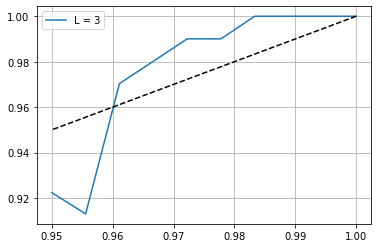

In [31]:
plt.figure()
for i_L, L in enumerate(L_list):
    plt.plot(1-p_list,(1-prob[i_L,:])**3 * (1-prob[i_L,:]),"-", color = "C%d" % i_L, label="L = %d" % L)
    # plt.plot(1-p_list,(1-prob_x[i_L,:]),"--", color = "C%d" % i_L, label="L = %d" % L)

plt.plot(1-p_list,1-p_list,"k--")
plt.legend()
plt.grid()
plt.show()

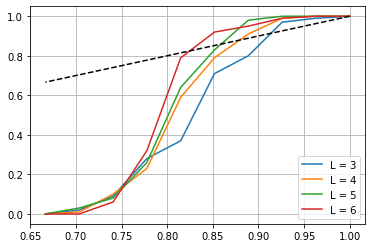

In [22]:
plt.figure()
for i_L, L in enumerate(L_list):
    plt.plot(1-p_list,(1-prob[i_L,:]),"-", color = "C%d" % i_L, label="L = %d" % L)
    # plt.plot(1-p_list,(1-prob_x[i_L,:]),"--", color = "C%d" % i_L, label="L = %d" % L)

plt.plot(1-p_list,1-p_list,"k--")
plt.legend()
plt.grid()
plt.show()

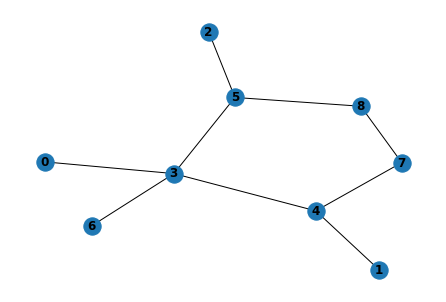

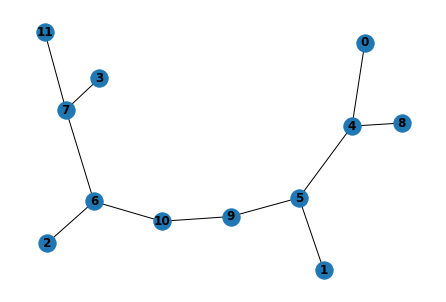

In [37]:
r1 = 3
r2 = r1

error_loss_x = np.random.rand((r1*r2)) 
p_x = 0.4
loss_inds_x = 2*np.argwhere(error_loss_x < p_x)[:,0]

error_loss_y = np.random.rand((r1*r2)) 
p_y = 1
loss_inds_y = 2*np.argwhere(error_loss_y < p_y)[:,0] + 1

loss_inds_Gy = np.sort(np.concatenate((loss_inds_x,loss_inds_y)))
does_percolate_y(r1,r2,loss_inds_Gy)
plt.show()


last_row = 2*np.arange((r2-1)*r1,r2*r1)+1
loss_inds_y = list(set(loss_inds_y)-set(last_row))
loss_inds_Gx = np.sort(np.concatenate((loss_inds_x,loss_inds_y)))
does_percolate_x(r1,r2,loss_inds_Gx)
plt.show()
            

## parity code

/tmp/ipykernel_4165/1203947825.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(p0,p5(p0)/p0,label="p5")
/tmp/ipykernel_4165/1203947825.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(p0,p5(p5(p0))/p0,label="p5 o p5")
/tmp/ipykernel_4165/1203947825.py:11: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(p0,p5(p5(p5(p0)))/p0,label="p5 o p5 o p5")


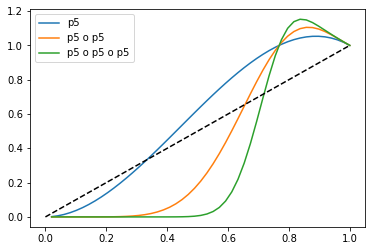

In [178]:
m = 4
n = 20
p0 = np.linspace(0,1)
# p1 = p**m * ( n*(1-(1-p)**m)**(n-1)
p5 = lambda x: x**4 + 4* x**3 * (1-x)
p2 = lambda p: (1-(1-p)**m)**n - (1-(1-p)**m-p**m)**n
# plt.plot(p,p1)
# plt.plot(p0,p2(p0),label="p2")
plt.plot(p0,p5(p0)/p0,label="p5")
plt.plot(p0,p5(p5(p0))/p0,label="p5 o p5")
plt.plot(p0,p5(p5(p5(p0)))/p0,label="p5 o p5 o p5")
# plt.plot(p0,p2(p2(p0)),label="p2 o p2")
# plt.plot(p0,p,"k--")
plt.plot(p0,p,"k--")
plt.legend()
plt.show()


In [110]:
p0[np.argwhere(p2(p0)>p0)[0]]

array([0.63265306])

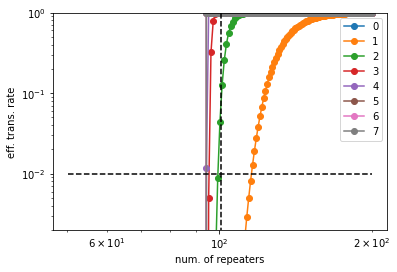

In [117]:
t0 = 0.01
L = 1000
tn = lambda n: 10**(-0.2/10*L/n)
p_th = 0.63265
Lopt = -np.log10(p_th)*10/0.2
nopt = L/Lopt
n_list = np.arange(0.5*nopt,2*nopt)
p_eff = tn(n_list+1)
Nc = 8 # concatenation level
for i_c in range(Nc):
    p_eff = p2(p_eff)
    plt.plot(n_list, p_eff**(n_list+1) ,"o-", label="%d" % (i_c))
plt.plot(n_list, t0+0*n_list,"k--")
plt.plot([nopt,nopt],[0,1],"k--")
plt.xlabel("num. of repeaters")
plt.ylabel("eff. trans. rate")
plt.xscale("log")
plt.yscale("log")
plt.ylim(2e-3,1)
plt.legend()
plt.show()

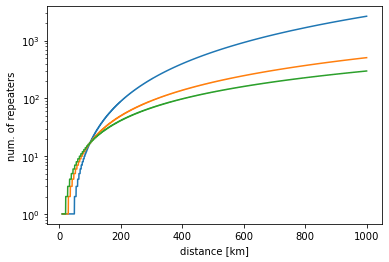

In [177]:
from scipy.optimize import fsolve, fmin_cobyla, fmin,root

m = 4
n = 20
p5 = lambda x: x**4 + 4* x**3 * (1-x)
p2 = lambda p: (1-(1-p)**m)**n - (1-(1-p)**m-p**m)**n

def constr1(x):
    return x

t0 = 0.01
L_list = np.linspace(10,1000,4000)

n_opt1 = np.zeros(len(L_list))
n_opt2 = np.zeros(len(L_list))
n_opt3 = np.zeros(len(L_list))


for i_L, L in enumerate(L_list):
    tn = lambda n: 10**(-0.2/10*L/n)
    # p_eff = lambda x: (p5(p5(p5(tn(x+1))))**(x+1) - t0)**2
    # sol = root(p_eff, [10], method='hybr')#, options={'xtol': 1e-1})
    # n_opt[i_L] = sol.x
    # n_opt[i_L] = fmin_cobyla(p_eff, [40], [constr1], rhoend=1e-20)
    n_list = np.arange(1,4001)
    n_opt1[i_L] = n_list[np.argwhere(p5(tn(n_list+1))**(n_list+1)>t0)[0]]
    n_opt2[i_L] = n_list[np.argwhere(p5(p5(tn(n_list+1)))**(n_list+1)>t0)[0]]
    n_opt3[i_L] = n_list[np.argwhere(p5(p5(p5(tn(n_list+1))))**(n_list+1)>t0)[0]]



# plt.plot(L_list,np.floor(n_opt)+1,".-")
plt.plot(L_list,n_opt1,"-",label="1")
plt.plot(L_list,n_opt2,"-",label="2")
plt.plot(L_list,n_opt3,"-",label="3")
plt.ylabel("num. of repeaters")
plt.xlabel("distance [km]")
# plt.xscale("log")
plt.yscale("log")
# plt.ylim(2e-3,1)
plt.show()

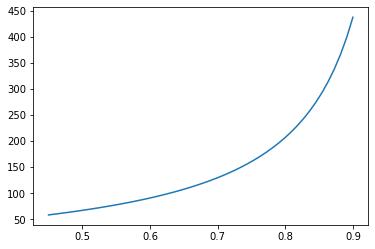

In [123]:
L = 1000
p_th_list = np.linspace(0.45,0.9)
Lopt_list = -np.log10(p_th_list)*10/0.2
nopt_list = L/Lopt_list
plt.plot(p_th_list,nopt_list)
plt.show()